In [1]:
import pandas as pd 
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklift.models import ClassTransformation, TwoModels
import pickle
import scikitplot as skplt
from sklearn.preprocessing import MinMaxScaler
from sklift.viz import plot_uplift_curve, plot_qini_curve, plot_uplift_preds
import kds
from sklift.metrics import uplift_at_k, uplift_auc_score 
import seaborn as sns 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [2]:
def age_range(values):
    if values > 0 and values <= 17:
        return 0 
    elif values > 17 and values <= 30:
        return 1 
    elif values > 30 and values <= 45 :
        return 2 
    elif values > 45 and values <= 60 :
        return 3 
    elif values >  60 and values <= 90:
        return 4 
    else :
        return 5
    
def summary_uplift(X_val,X_test,y_val,y_test,model):
    pred_val =  np.where(model.predict(X_val) <= 0, 0, 1)
    pred_test =  np.where(model.predict(X_test) <= 0, 0, 1)
    print('f1 score for validation set {}'.format(f1_score(y_val, pred_val, average='binary')))
    print('f1 score for test set {}'.format(f1_score(y_test, pred_test, average='binary')))
    print('acc score for validation set {}'.format(accuracy_score(y_val, pred_val)))
    print('acc score for test set {}'.format(accuracy_score(y_test, pred_test)))
    
    
def summary_conv(X_val,X_test,y_val,y_test,model):
    pred_val =  model.predict(X_val)
    pred_test =  model.predict(X_test) 
    print('f1 score for validation set {}'.format(f1_score(y_val, pred_val, average='binary')))
    print('f1 score for test set {}'.format(f1_score(y_test, pred_test, average='binary')))
    print('acc score for validation set {}'.format(accuracy_score(y_val, pred_val)))
    print('acc score for test set {}'.format(accuracy_score(y_test, pred_test)))
    
def data_preprocessing(df_feature, df_products, df_store, prod_columns, store_columns, cat_columns, num_columns):
    # clean up, imputation 
    # label encoder 
    
    # split numeric and categorical columns 

#     categorical_columns = list(df_feature.select_dtypes(include=['object']).columns)
#     categorical_columns = categorical_columns[1:]

#     numeric_columns =  list(df_feature.select_dtypes(include=['float64']).columns)
    # numeric_columns = numeric_columns
    
    # fill null columns on numeric columns 
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    df_feature[numeric_columns] = imp.fit_transform(df_feature[numeric_columns])

    # fill null columns on numeric columns 
    imp2 = SimpleImputer(strategy="most_frequent")
    df_feature[categorical_columns] = imp2.fit_transform(df_feature[categorical_columns])

    # fill null columns on numeric columns 
    imp3 = SimpleImputer(strategy="most_frequent",missing_values='U')
    df_feature['gender'] = imp3.fit_transform(df_feature['gender'].values.reshape(-1,1))
    
    # preprocessing 
    le_store = preprocessing.LabelEncoder()
    le_prod = preprocessing.LabelEncoder()
    le_gender = preprocessing.LabelEncoder()

    le_prod.fit(df_product['product_id'])
    le_store.fit(df_store['store_id'])
    le_gender.fit(df_feature['gender'])

    # product 
    for col in prod_columns:
        df_feature[col] = le_prod.transform(df_feature[col])

    # store 
    for col in store_columns:
        df_feature[col] = le_store.transform(df_feature[col])

    df_feature['gender'] = le_gender.transform(df_feature['gender'])
    
    return df_feature

In [37]:
# load features 
df_store = pd.read_csv('../../data/unique_store.csv/part-00000-d7453c53-4a48-4ff3-85f3-1e665ea60e07-c000.csv')


# first feature 
df_feature = pd.read_csv('../../data/feature_stg1.csv/part-00000-13c76568-33bb-4aaa-bb62-1bbeaf144bcb-c000.csv')
df_feature['first_issue_date']= pd.to_datetime(df_feature['first_issue_date'])
df_feature['first_redeem_date'] = pd.to_datetime(df_feature['first_redeem_date'])
df_feature['first_redeem_date'] = df_feature['first_redeem_date'].fillna(df_feature['first_redeem_date'].max())
df_feature['delta_days'] = (df_feature['first_redeem_date'] - df_feature['first_issue_date']).dt.days
# df_feature = df_feature.drop(['first_issue_date','first_redeem_date'],axis=1)
df_feature['age_group'] = df_feature['age'].apply(age_range)

# 2nd feature 
# df_feature = pd.read_csv('../../data/feature_stg2.csv/part-00000-e82c3679-6f34-41e2-827b-d51e0fb813dc-c000.csv')
# df_cli = pd.read_csv('../../data/data/clients.csv')
# df_up_train = pd.read_csv('../../data/data/uplift_train.csv')
# df_feature = pd.merge(df_feature,df_cli,left_on='client_id',right_on = 'client_id',how='inner')
# df_feature = pd.merge(df_feature,df_up_train,left_on='client_id',right_on = 'client_id',how='inner')
# df_feature = df_feature.drop(['first_issue_date','first_redeem_date'],axis=1)
# df_feature['age_group'] = df_feature['age'].apply(age_range)


# load products data 
df_product = pd.read_csv('../../data/data/products.csv')

In [39]:
df_feature.head()

,client_id,treatment_flg,target,first_issue_date,first_redeem_date,age,gender,m_1_rpr,m_11_rpr,m_12_rpr,m_2_rpr,m_3_rpr,m_1_eps,m_11_eps,m_12_eps,m_2_eps,m_3_eps,m_1_ps,m_11_ps,m_12_ps,m_2_ps,m_3_ps,m_1_rps,m_11_rps,m_12_rps,m_2_rps,m_3_rps,m_1_prd_qty_val,m_11_prd_qty_val,m_12_prd_qty_val,m_2_prd_qty_val,m_3_prd_qty_val,m_1_prd_pur,m_11_prd_pur,m_12_prd_pur,m_2_prd_pur,m_3_prd_pur,m_1_prd_pur_qty,m_11_prd_pur_qty,m_12_prd_pur_qty,m_2_prd_pur_qty,m_3_prd_pur_qty,m_1_prd_pur_sum,m_11_prd_pur_sum,m_12_prd_pur_sum,m_2_prd_pur_sum,m_3_prd_pur_sum,m_1_str_top_qty,m_11_str_top_qty,m_12_str_top_qty,m_2_str_top_qty,m_3_str_top_qty,m_1_str_top_pur,m_11_str_top_pur,m_12_str_top_pur,m_2_str_top_pur,m_3_str_top_pur,m_1_str_top_qty_val,m_11_str_top_qty_val,m_12_str_top_qty_val,m_2_str_top_qty_val,m_3_str_top_qty_val,m_1_str_top_pur_val,m_11_str_top_pur_val,m_12_str_top_pur_val,m_2_str_top_pur_val,m_3_str_top_pur_val,delta_days,age_group
0,00f6cab0d9,0,1,2017-09-14 15:27:21,2017-12-25 16:27:54,48,U,17.6,NaN,26.5,11.1,13.2,0.0,NaN,0.0,0.0,0.0,2533.37,NaN,2844.54,1360.99,1732.33,0.0,NaN,0.0,0.0,0.0,4009f09b04,NaN,4009f09b04,4009f09b04,4009f09b04,4009f09b04,NaN,4009f09b04,4009f09b04,4009f09b04,5.0,NaN,4.0,3.0,3.0,2533.37,NaN,2844.54,1360.99,1601.13,6f953e34e7,NaN,6f953e34e7,6f953e34e7,6f953e34e7,6f953e34e7,NaN,6f953e34e7,6f953e34e7,6f953e34e7,83.0,NaN,83.0,83.0,83.0,1811.24,NaN,2844.54,1360.99,1732.33,102,3
1,010c5002de,1,1,2018-10-24 12:43:19,2018-11-12 21:39:30,27,M,3.2,3.0,8.6,5.4,3.5,-30.0,0.0,0.0,-30.0,0.0,970.41,307.56,1537.70,1163.03,728.48,-24.0,0.0,0.0,-6.0,0.0,b35e34907a,51bdfd2ddc,dd84e5153b,51dc63b6fd,95b0eb283e,b35e34907a,51bdfd2ddc,9d4159b0d0,51dc63b6fd,6b298e70f9,1.0,1.0,2.0,2.0,1.0,429.96,307.56,588.62,619.36,318.85,811c3845bd,811c3845bd,811c3845bd,811c3845bd,811c3845bd,811c3845bd,811c3845bd,811c3845bd,811c3845bd,811c3845bd,40.0,40.0,40.0,40.0,40.0,749.84,307.56,1537.70,764.03,728.48,19,1
2,018253c9e4,0,0,2018-01-19 18:00:10,2018-11-29 15:13:23,78,U,16.4,0.0,28.6,12.5,0.6,0.0,0.0,0.0,0.0,0.0,1651.00,309.00,3077.00,1706.00,223.00,0.0,-309.0,0.0,0.0,-100.0,dafacf9991,195815994c,d7c47dfa9b,5645789fdf,fc2811d84a,e7882af1a6,74d502f3c1,d7c47dfa9b,5645789fdf,fc2811d84a,1.0,1.0,2.0,2.0,1.0,972.00,179.00,2661.00,893.00,223.00,d19ef06705,d19ef06705,d19ef06705,d19ef06705,d8fc0e5abd,d8fc0e5abd,d19ef06705,d19ef06705,d19ef06705,d8fc0e5abd,39.0,39.0,39.0,39.0,28.0,972.00,309.00,2196.00,813.00,223.00,313,4
3,02429418df,0,0,2017-12-30 15:35:36,2019-08-09 19:56:05,23,M,NaN,NaN,13.4,15.9,8.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,1349.00,1876.70,931.07,NaN,NaN,0.0,0.0,0.0,NaN,NaN,4dcf79043e,4009f09b04,a67e072174,NaN,NaN,4dcf79043e,4009f09b04,4a29330c8d,NaN,NaN,1.0,2.0,1.0,NaN,NaN,1349.00,1841.70,582.07,NaN,NaN,d09acf8114,2fe93e36be,68c6d6a626,NaN,NaN,d09acf8114,2fe93e36be,68c6d6a626,NaN,NaN,10.0,21.0,10.0,NaN,NaN,1349.00,1337.70,582.07,587,1
4,026466cca4,1,1,2018-08-06 18:49:42,2018-12-08 15:47:46,26,U,14.1,NaN,17.3,5.0,NaN,0.0,NaN,-30.0,0.0,NaN,2046.90,NaN,2317.45,1029.14,NaN,0.0,NaN,-100.0,0.0,NaN,614c05e0f4,NaN,fec7fcf3a6,f05df41452,NaN,b44b9c16df,NaN,fb79e85e0e,f05df41452,NaN,2.0,NaN,2.0,1.0,NaN,832.97,NaN,1100.48,495.53,NaN,d93d341c66,NaN,d93d341c66,d93d341c66,NaN,d93d341c66,NaN,d93d341c66,d93d341c66,NaN,69.0,NaN,69.0,69.0,NaN,1529.20,NaN,2317.45,916.48,NaN,123,1


In [40]:
## 1st feature 
prod_cat_columns = ['m_1_prd_qty_val', 'm_11_prd_qty_val', 'm_12_prd_qty_val', 'm_2_prd_qty_val', 'm_3_prd_qty_val',
               'm_1_prd_pur','m_11_prd_pur','m_12_prd_pur','m_2_prd_pur','m_3_prd_pur']
store_cat_columns = ['m_1_str_top_qty', 'm_11_str_top_qty', 'm_12_str_top_qty', 'm_2_str_top_qty', 'm_3_str_top_qty',
     'm_1_str_top_pur','m_11_str_top_pur','m_12_str_top_pur','m_2_str_top_pur','m_3_str_top_pur']

categorical_columns = list(df_feature.select_dtypes(include=['object']).columns)
categorical_columns = categorical_columns[1:]

numeric_columns =  list(df_feature.select_dtypes(include=['float64']).columns)

## 2nd feature 
# prod_cat_columns = ['product_pur','product_qty']
# store_cat_columns = ['store_id_pur_qty','store_id_pur']
df_feature = data_preprocessing(df_feature, df_product, df_store,prod_cat_columns,store_cat_columns, categorical_columns, numeric_columns)

In [24]:
df_feature.head()

,client_id,treatment_flg,target,age,gender,m_1_rpr,m_11_rpr,m_12_rpr,m_2_rpr,m_3_rpr,m_1_eps,m_11_eps,m_12_eps,m_2_eps,m_3_eps,m_1_ps,m_11_ps,m_12_ps,m_2_ps,m_3_ps,m_1_rps,m_11_rps,m_12_rps,m_2_rps,m_3_rps,m_1_prd_qty_val,m_11_prd_qty_val,m_12_prd_qty_val,m_2_prd_qty_val,m_3_prd_qty_val,m_1_prd_pur,m_11_prd_pur,m_12_prd_pur,m_2_prd_pur,m_3_prd_pur,m_1_prd_pur_qty,m_11_prd_pur_qty,m_12_prd_pur_qty,m_2_prd_pur_qty,m_3_prd_pur_qty,m_1_prd_pur_sum,m_11_prd_pur_sum,m_12_prd_pur_sum,m_2_prd_pur_sum,m_3_prd_pur_sum,m_1_str_top_qty,m_11_str_top_qty,m_12_str_top_qty,m_2_str_top_qty,m_3_str_top_qty,m_1_str_top_pur,m_11_str_top_pur,m_12_str_top_pur,m_2_str_top_pur,m_3_str_top_pur,m_1_str_top_qty_val,m_11_str_top_qty_val,m_12_str_top_qty_val,m_2_str_top_qty_val,m_3_str_top_qty_val,m_1_str_top_pur_val,m_11_str_top_pur_val,m_12_str_top_pur_val,m_2_str_top_pur_val,m_3_str_top_pur_val,delta_days,age_group
0,00f6cab0d9,0,1,48,0,17.6,4.4,26.5,11.1,13.2,0.0,0.0,0.0,0.0,0.0,2533.37,698.865,2844.54,1360.99,1732.330,0.0,0.0,0.0,0.0,0.0,10810,10810,10810,10810,10810,10810,10810,10810,10810,10810,5.0,1.0,4.0,3.0,3.0,2533.370,537.63,2844.54,1360.99,1601.13,6022,12871,6022,6022,6022,6022,12871,6022,6022,6022,83.0,57.0,83.0,83.0,83.0,1811.240,618.27,2844.54,1360.99,1732.330,102,3
1,010c5002de,1,1,27,1,3.2,3.0,8.6,5.4,3.5,-30.0,0.0,0.0,-30.0,0.0,970.41,307.560,1537.70,1163.03,728.480,-24.0,0.0,0.0,-6.0,0.0,29983,13763,37180,13783,25083,29983,13763,26353,13783,17964,1.0,1.0,2.0,2.0,1.0,429.960,307.56,588.62,619.36,318.85,6960,6960,6960,6960,6960,6960,6960,6960,6960,6960,40.0,40.0,40.0,40.0,40.0,749.840,307.56,1537.70,764.03,728.480,19,1
2,018253c9e4,0,0,78,0,16.4,0.0,28.6,12.5,0.6,0.0,0.0,0.0,0.0,0.0,1651.00,309.000,3077.00,1706.00,223.000,0.0,-309.0,0.0,0.0,-100.0,36778,4261,36258,14501,42383,38892,19639,36258,14501,42383,1.0,1.0,2.0,2.0,1.0,972.000,179.00,2661.00,893.00,223.00,11440,11440,11440,11440,11809,11809,11440,11440,11440,11809,39.0,39.0,39.0,39.0,28.0,972.000,309.00,2196.00,813.00,223.000,313,4
3,02429418df,0,0,23,1,11.3,4.4,13.4,15.9,8.0,0.0,0.0,0.0,0.0,0.0,1618.00,698.865,1349.00,1876.70,931.070,0.0,0.0,0.0,0.0,0.0,10810,10810,13091,10810,27821,10810,10810,13091,10810,12454,2.0,1.0,1.0,2.0,1.0,1002.405,537.63,1349.00,1841.70,582.07,11336,12871,11379,2524,5653,11336,12871,11379,2524,5653,53.0,57.0,10.0,21.0,10.0,1285.905,618.27,1349.00,1337.70,582.070,587,1
4,026466cca4,1,1,26,0,14.1,4.4,17.3,5.0,8.4,0.0,0.0,-30.0,0.0,0.0,2046.90,698.865,2317.45,1029.14,1163.165,0.0,0.0,-100.0,0.0,0.0,16313,10810,42851,40393,10810,30166,10810,42286,40393,10810,2.0,1.0,2.0,1.0,2.0,832.970,537.63,1100.48,495.53,801.00,11822,12871,11822,11822,11336,11822,12871,11822,11822,11336,69.0,57.0,69.0,69.0,46.0,1529.200,618.27,2317.45,916.48,967.835,123,1


In [25]:
df_feature.groupby(['treatment_flg','target']).size()

treatment_flg  target
0              0         39695
               1         60363
1              0         36342
               1         63639
dtype: int64

# Target share for treatment / control

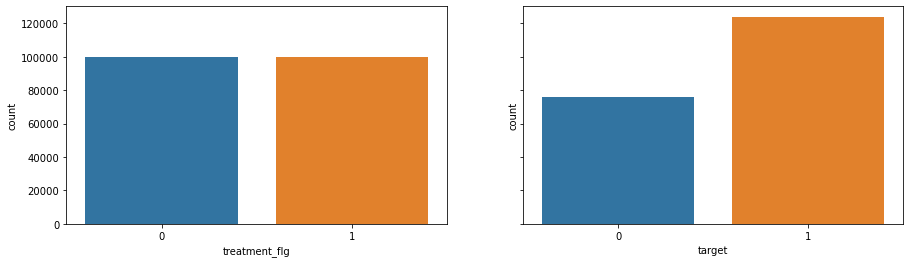

In [26]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,4))

treatment = df_feature["treatment_flg"]
target = df_feature["target"]

sns.countplot(x=treatment, ax=ax[0])
sns.countplot(x=target, ax=ax[1])

In [27]:
# split dataset 

# train and validation 
X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split( df_feature.drop(['client_id','treatment_flg', 'target','age'],axis=1), df_feature['treatment_flg'], df_feature['target'], 
    test_size=0.4,
    random_state=42
)

# test and validation 
X_val, X_test, trmnt_val, trmnt_test, y_val, y_test = train_test_split(X_val, trmnt_val , y_val,
    test_size=0.5,
    random_state=42
)


In [28]:
X_train.shape, X_val.shape, X_test.shape

((120023, 63), (40008, 63), (40008, 63))

In [29]:
X_train.head()

,gender,m_1_rpr,m_11_rpr,m_12_rpr,m_2_rpr,m_3_rpr,m_1_eps,m_11_eps,m_12_eps,m_2_eps,m_3_eps,m_1_ps,m_11_ps,m_12_ps,m_2_ps,m_3_ps,m_1_rps,m_11_rps,m_12_rps,m_2_rps,m_3_rps,m_1_prd_qty_val,m_11_prd_qty_val,m_12_prd_qty_val,m_2_prd_qty_val,m_3_prd_qty_val,m_1_prd_pur,m_11_prd_pur,m_12_prd_pur,m_2_prd_pur,m_3_prd_pur,m_1_prd_pur_qty,m_11_prd_pur_qty,m_12_prd_pur_qty,m_2_prd_pur_qty,m_3_prd_pur_qty,m_1_prd_pur_sum,m_11_prd_pur_sum,m_12_prd_pur_sum,m_2_prd_pur_sum,m_3_prd_pur_sum,m_1_str_top_qty,m_11_str_top_qty,m_12_str_top_qty,m_2_str_top_qty,m_3_str_top_qty,m_1_str_top_pur,m_11_str_top_pur,m_12_str_top_pur,m_2_str_top_pur,m_3_str_top_pur,m_1_str_top_qty_val,m_11_str_top_qty_val,m_12_str_top_qty_val,m_2_str_top_qty_val,m_3_str_top_qty_val,m_1_str_top_pur_val,m_11_str_top_pur_val,m_12_str_top_pur_val,m_2_str_top_pur_val,m_3_str_top_pur_val,delta_days,age_group
121158,0,45.0,1.0,24.3,7.4,4.6,0.0,0.0,0.0,0.0,0.0,4945.22,222.960,2927.00,744.85,954.00,0.0,0.0,-218.0,0.0,0.0,10810,12014,10810,2612,10810,10810,5750,10810,2612,10810,5.0,1.0,2.0,1.0,2.0,4357.220,137.97,1832.00,744.85,837.00,2294,2294,2294,1462,2294,2294,2294,2294,1462,2294,92.0,92.0,92.0,10.0,92.0,3969.220,137.97,2927.00,744.85,837.00,72,1
165219,0,4.3,4.4,32.5,5.9,8.6,0.0,0.0,0.0,0.0,0.0,654.00,698.865,2723.98,1169.00,1052.00,0.0,0.0,-14.0,-23.0,0.0,38484,10810,18306,14501,17569,42262,10810,11424,6684,17569,1.0,1.0,2.0,2.0,1.0,233.000,537.63,1881.00,755.00,706.00,10481,12871,10481,10481,10481,10481,12871,10481,2843,10481,26.0,57.0,26.0,26.0,26.0,421.000,618.27,1511.98,493.00,706.00,9,4
166775,0,11.3,4.4,18.1,0.8,6.2,0.0,0.0,0.0,0.0,0.0,1618.00,698.865,1840.37,171.00,684.00,0.0,0.0,0.0,0.0,0.0,10810,10810,42384,20707,368,10810,10810,41494,10510,368,2.0,1.0,2.0,1.0,1.0,1002.405,537.63,1135.00,88.00,575.00,11336,12871,9682,13168,9682,11336,12871,11050,13168,9682,53.0,57.0,24.0,7.0,24.0,1285.905,618.27,1482.00,171.00,684.00,369,1
118614,1,3.6,0.2,4.9,3.3,24.9,0.0,0.0,0.0,0.0,0.0,1367.61,47.000,1010.90,718.93,2991.88,0.0,0.0,0.0,-21.0,0.0,38018,38160,2362,38523,35941,38018,38160,2362,38523,10810,2.0,1.0,2.0,3.0,2.0,562.550,47.00,890.93,718.93,2054.22,12357,1700,12357,1700,12357,12357,1700,12357,1700,12357,29.0,18.0,29.0,18.0,29.0,1196.440,47.00,563.96,718.93,2248.61,88,2
35717,1,2.1,4.4,1.4,1.2,0.1,0.0,0.0,0.0,0.0,0.0,345.88,698.865,176.77,269.62,39.10,0.0,0.0,0.0,0.0,0.0,17376,10810,1062,12859,6346,17376,10810,3698,12859,6346,2.0,1.0,1.0,1.0,1.0,208.380,537.63,72.99,104.49,39.10,1182,12871,1182,1182,1182,1182,12871,1182,1182,1182,16.0,57.0,16.0,16.0,16.0,345.880,618.27,176.77,269.62,39.10,345,1


#  conventional model 

In [44]:
%%time

#catboost 
# model_cat_conv = CatBoostClassifier(iterations=1500,task_type="GPU",cat_features=categorical_columns, verbose = 0, border_count = 150, l2_leaf_reg=5, depth =4,
#                            devices='0:1', learning_rate=0.03)
# model_cat_conv.fit(X_train,y_train, eval_set=(X_val, y_val))
model_cat_conv = CatBoostClassifier(learning_rate=0.03, verbose = 0, task_type="GPU")
model_cat_conv.fit(X_train,y_train, eval_set=(X_val, y_val))
model_cat_conv.save_model('../../data/data/dft_catboost_feat_stg1',
           format="cbm",
           export_parameters=None,
           pool=None)
# model_cat_conv.load_model('../../data/data/dft_catboost_feat_stg1')

Wall time: 18.4 s


In [46]:
print('CatBoost performance')
summary_conv(X_val,X_test,y_val,y_test,model_cat_conv)

CatBoost performance
f1 score for validation set 0.7773628712392378
f1 score for test set 0.7764875221256151
acc score for validation set 0.712382523495301
acc score for test set 0.7127824435112977


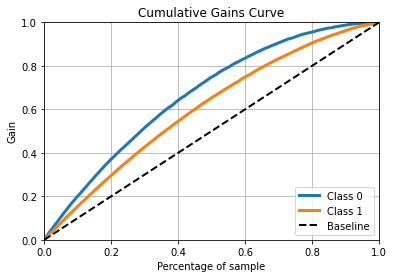

In [47]:
predicted_probas = model_cat_conv.predict_proba(X_val)
skplt.metrics.plot_cumulative_gain(y_val, predicted_probas)

In [50]:
%%time
model_xgb_conv = XGBClassifier(use_label_encoder=False, eval_metric='error', learning_rate = 0.03, gpu_id=0)
model_xgb_conv = model_xgb_conv.fit(X_train, y_train)
model_xgb_conv.save_model("../../data/data/dft_xgb_feat_stg1.json")
# model_xgb_conv.load_model('../../data/data/dft_xgb_feat_stg1.json')

Wall time: 27.3 s


In [51]:
print('XGB performance ')
summary_conv(X_val,X_test,y_val,y_test,model_xgb_conv)

XGB performance 
f1 score for validation set 0.775250262179426
f1 score for test set 0.7762756716332049
acc score for validation set 0.7053839232153569
acc score for test set 0.7083833233353329


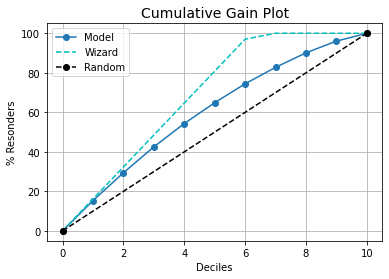

In [52]:
predicted_probas = model_xgb_conv.predict_proba(X_val)
# skplt.metrics.plot_cumulative_gain(y_val, predicted_probas)
kds.metrics.plot_cumulative_gain(y_val, predicted_probas[:,1])

In [26]:
# model_xgb_conv.save_model("../../data/data/dft_xgb_feat_stg1.json")

# uplift XGBoost

In [54]:
%%time
# Classtransformation 
# define approach
ct_xgb = ClassTransformation(XGBClassifier(random_state=777,eval_metric='error', gpu_id=0 ))

# # fit the model
ct_xgb = ct_xgb.fit(X_train, y_train, trmnt_train)

# save model 
filename = '../../data/data/up_ct_xgb_dft_catboost_feat_stg1.pickle'
pickle.dump(ct_xgb, open(filename, 'wb'))

#load model 
# ct_xgb = pickle.load(open(filename, 'rb'))

C:\Users\adama\Anaconda2\envs\mypython36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Wall time: 22.1 s


In [55]:
print('F1 XGBoost class transformation')
summary_uplift(X_val,X_test,y_val,y_test,ct_xgb)

F1 XGBoost class transformation
f1 score for validation set 0.6068252823840423
f1 score for test set 0.6062392237058423
acc score for validation set 0.5092981403719257
acc score for test set 0.5090981803639272


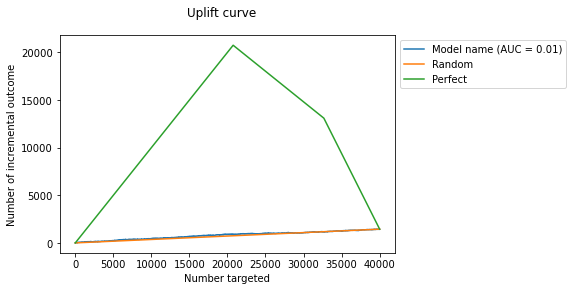

In [56]:
# scaler = MinMaxScaler()
# predicted_probas = ct_xgb.predict(X_val)
# predicted_probas =  scaler.fit_transform(ct_xgb.predict(X_val).reshape(-1,1))
# skplt.metrics.plot_cumulative_gain(y_val, predicted_probas[:, 0])

uplift_predicted = ct_xgb.predict(X_test)

uplift_disp = plot_uplift_curve(
    y_test, uplift_predicted, trmnt_test,
    perfect=True, name='Model name'
);

uplift_disp.figure_.suptitle("Uplift curve");

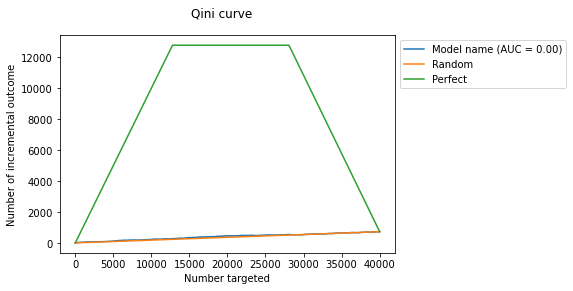

In [57]:
qini_disp = plot_qini_curve(
    y_test, uplift_predicted, trmnt_test,
    perfect=True, name='Model name'
);

qini_disp.figure_.suptitle("Qini curve");

In [58]:
uplift_predictions  = ct_xgb.predict(X_val)

uplift_30 = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='overall')
print(f'uplift@30%: {uplift_30:.4f}')

uplift@30%: 0.0429


In [42]:
uplift_auc_score(y_val, uplift_predictions, trmnt_val)

0.006525132735887514

In [62]:
%%time
# two model 

estimator_trmnt_xgb = XGBClassifier(random_state=777,eval_metric='error', gpu_id=0 )
estimator_ctrl_xgb = XGBClassifier(random_state=777,eval_metric='error', gpu_id=0 )


# define approach
tm_ctrl_xgb = TwoModels(
    estimator_trmnt=estimator_trmnt_xgb,
    estimator_ctrl=estimator_ctrl_xgb,
    method='ddr_control'
)

tm_ctrl_xgb = tm_ctrl_xgb.fit(
    X_train, y_train, trmnt_train
)

# save model 
filename = '../../data/data/up_tm_xgb_dft_catboost_feat_stg1.pickle'
pickle.dump(tm_ctrl_xgb, open(filename, 'wb'))

#load model 
# tm_ctrl_xgb = pickle.load(open(filename, 'rb'))

C:\Users\adama\Anaconda2\envs\mypython36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Wall time: 26.5 s


In [63]:
print('F1 XGBoost two model')
summary_uplift(X_val,X_test,y_val,y_test,tm_ctrl_xgb)

F1 XGBoost two model
f1 score for validation set 0.625427081460169
f1 score for test set 0.6212448066474913
acc score for validation set 0.5314187162567486
acc score for test set 0.5260447910417917


In [45]:
uplift_predictions  = tm_ctrl_xgb.predict(X_val)
uplift_auc_score(y_val, uplift_predictions, trmnt_val)

0.007326151696090458

# uplift Catboost

In [66]:
%%time
# Classtransformation 
# define approach
ct_cat = ClassTransformation(CatBoostClassifier(verbose=0, random_state=777, task_type="GPU"))
# # fit the model
ct_cat = ct_cat.fit(X_train, y_train, trmnt_train)

# save model 
filename = '../../data/data/up_ct_cat_dft_catboost_feat_stg1.pickle'
pickle.dump(ct_cat, open(filename, 'wb'))

# #load model 
# ct_cat = pickle.load(open(filename, 'rb'))

Wall time: 15 s


In [67]:
print('F1 Catboost class transformation')
summary_uplift(X_val,X_test,y_val,y_test,ct_cat)

F1 Catboost class transformation
f1 score for validation set 0.6613808690580344
f1 score for test set 0.6606736665878115
acc score for validation set 0.5356428714257149
acc score for test set 0.5339182163567286


In [68]:
uplift_predictions  = ct_cat.predict(X_val)
uplift_auc_score(y_val, uplift_predictions, trmnt_val)

0.013760602605051122

In [70]:
%%time
# two model 

estimator_trmnt_cat = CatBoostClassifier(silent=True, thread_count=2, random_state=42,task_type="GPU")
estimator_ctrl_cat = CatBoostClassifier(silent=True, thread_count=2, random_state=42,task_type="GPU")

# define approach
tm_ctrl_cat = TwoModels(
    estimator_trmnt=estimator_trmnt_cat,
    estimator_ctrl=estimator_ctrl_cat,
    method='ddr_control'
)

tm_ctrl_cat = tm_ctrl_cat.fit(
    X_train, y_train, trmnt_train
)

# save model 
filename = '../../data/data/up_tm_cat_dft_catboost_feat_stg1.pickle'
pickle.dump(tm_ctrl_cat, open(filename, 'wb'))

# #load model 
# tm_ctrl_cat = pickle.load(open(filename, 'rb'))

Wall time: 25.6 s


In [71]:
print('F1 Catboost two model')
summary_uplift(X_val,X_test,y_val,y_test,tm_ctrl_cat)

F1 Catboost two model
f1 score for validation set 0.7075648556481995
f1 score for test set 0.7066797818116785
acc score for validation set 0.5906068786242752
acc score for test set 0.5900569886022795


In [72]:
uplift_predictions  = tm_ctrl_cat.predict(X_val)
uplift_auc_score(y_val, uplift_predictions, trmnt_val)

0.018116621534492672

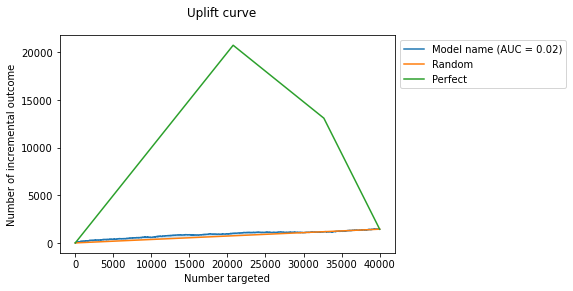

In [73]:
uplift_predicted = tm_ctrl_cat.predict(X_test)

uplift_disp = plot_uplift_curve(
    y_test, uplift_predicted, trmnt_test,
    perfect=True, name='Model name'
);

uplift_disp.figure_.suptitle("Uplift curve");

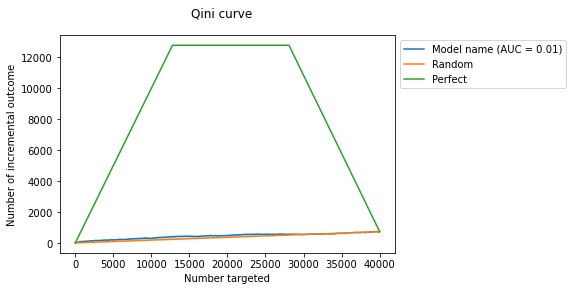

In [74]:
qini_disp = plot_qini_curve(
    y_test, uplift_predicted, trmnt_test,
    perfect=True, name='Model name'
);

qini_disp.figure_.suptitle("Qini curve");

In [75]:
from sklift.metrics import uplift_by_percentile

uplift_by_percentile(y_test, uplift_predicted, trmnt_test, 
                     strategy='overall', 
                     total=True, std=True, bins=10)


C:\Users\adama\Anaconda2\envs\mypython36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,2018,1983,0.560951,0.470499,0.090452,0.011047,0.011209,0.015738
10-20,2045,1956,0.578484,0.533231,0.045253,0.010920,0.011280,0.015700
20-30,2029,1972,0.631345,0.580122,0.051224,0.010710,0.011114,0.015435
30-40,1990,2011,0.651256,0.628046,0.023211,0.010683,0.010778,0.015175
40-50,2049,1952,0.688629,0.661373,0.027256,0.010230,0.010711,0.014811
50-60,1944,2057,0.720679,0.669421,0.051258,0.010176,0.010372,0.014530
60-70,2009,1992,0.700846,0.704819,-0.003973,0.010216,0.010220,0.014450
70-80,2014,1987,0.679742,0.676900,0.002842,0.010397,0.010491,0.014770
80-90,1984,2016,0.620968,0.578373,0.042595,0.010892,0.010998,0.015479


In [91]:
df_feat_imp = pd.DataFrame([
    ct_xgb\
        .estimator\
        .get_booster()\
        .get_score(importance_type='gain')
        ]
).T.reset_index()

df_feat_imp.head()

,index,0
0,m_3_eps,8.259708
1,m_3_str_top_pur_val,7.347496
2,m_12_rpr,6.199427
3,m_3_prd_qty_val,6.500044
4,m_3_rpr,5.995681


In [97]:
df_feat_imp = pd.DataFrame([
    ct_cat\
        .estimator\
        .get_feature_importance()\
        ]
).T.reset_index()

df_feat_imp.columns = ['idx','score']
df_feat_imp['cols'] = X_test.columns

df_feat_imp.sort_values('score',ascending=False)

,idx,score,cols
61,61,3.458601,delta_days
28,28,2.905541,m_12_prd_pur
25,25,2.713758,m_3_prd_qty_val
30,30,2.708306,m_3_prd_pur
29,29,2.671492,m_2_prd_pur
21,21,2.560636,m_1_prd_qty_val
23,23,2.462965,m_12_prd_qty_val
24,24,2.439939,m_2_prd_qty_val
22,22,2.328128,m_11_prd_qty_val
1,1,2.284414,m_1_rpr
